# パッケージ

In [1]:
import itertools

In [1]:
import numpy as np
import pandas as pd

In [2]:
import random
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch

In [6]:
import CLA

ModuleNotFoundError: No module named 'CLA'

In [3]:
[lag for lag in 5.5]

TypeError: 'float' object is not iterable

In [5]:
np.arange(5).reshape(-1, 1)

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [6]:
# 乱数列とそれと相関のある乱数列をデータフレームにまとめて出力
def generateData(nObs, size0, size1, sigma1):
    # 乱数シードの設定
    np.random.seed(seed=12345); random.seed(12345)
    # 正規乱数
    x=np.random.normal(0, 1, size=(nObs, size0))
    # 指定範囲の整数をランダムに生成
    cols = [random.randint(0, size0-1) for i in range(size1)]
    # xからランダムに列を選択し、正規乱数を加算
    y=x[:, cols] + np.random.normal(0, sigma1, size=(nObs, len(cols)))
    # xとyの全列をまとめる
    x=np.append(x, y, axis=1)
    # データフレームに変換
    x=pd.DataFrame(x, columns=range(1, x.shape[1]+1))
    return x, cols

In [4]:
# 相関行列をヒートマップで表示
# def plotCorrMatrix(path, corr, labels=None):
def plotCorrMatrix(corr, labels=None):
    if labels is None: labels=[]
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5, corr.shape[0]+.5), labels)
    mpl.xticks(np.arange(.5, corr.shape[0]+.5), labels)
    # mpl.savefig(path)
    # mpl.clf(); mpl.close()
    mpl.show()
    return

In [13]:
# 相関行列を距離行列に変換
def correlDist(corr):
    dist=((1-corr)/2.)**.5
    return dist

In [5]:
# 要素をクラスター順に並べる
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

In [54]:
def getRecBipart(cov, sortIx):
    w=pd.Series(1, index=sortIx)
    cItems=[sortIx]
    while len(cItems)>0:
        # 要素番号列を2分割
        # cItems=[i[j:k] for i in cItems for j,k in ((0, len(i)/2), (len(i)/2, len(i))) if len(i)>1]
        cItems=[i[j:k] for i in cItems for j,k in ((0, int(len(i)/2)), (int(len(i)/2), len(i))) if len(i)>1]
        for i in range(0, len(cItems), 2):
            # 前半要素
            cItems0=cItems[i]
            # 後半要素
            cItems1=cItems[i+1]
            # 分散の逆数をウェイトとしたポート（最適ウェイト）の分散
            cVar0=getClusterVar(cov, cItems0)
            cVar1=getClusterVar(cov, cItems1)
            # 分割係数
            alpha=1-cVar0/(cVar0+cVar1)
            # 両者の分散の逆数をウェイトにする
            w[cItems0]*=alpha
            w[cItems1]*=1-alpha
    return w

In [55]:
# 指定した分散ベクトルの逆数ウェイトポートの分散を返す
def getClusterVar(cov, cItems):
    # 指定列の分散ベクトルを取得
    cov_=cov.loc[cItems, cItems] 
    # 分散ベクトルの逆数を100分比にして返す
    w_=getIVP(cov_).reshape(-1, 1)
    # 当該ウェイトの分散を算出
    cVar=np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return cVar

In [56]:
# 分散ベクトルの逆数を100分比にして返す
def getIVP(cov, **karggs):
    # 各要素の分散の逆数
    ivp=1./np.diag(cov)
    # 100分比に変換
    ivp/=ivp.sum()
    return ivp

In [52]:
cItems=[i[j:k] for i in cItems for j,k in ((0, int(len(i)/2)), (int(len(i)/2), len(i))) if len(i)>1]

In [53]:
cItems

[]

In [61]:
int(len(cItems)/2)

0

In [49]:
len(cItems)

8

In [34]:
cVar0=getClusterVar(cov, cItems0)

In [35]:
cVar1=getClusterVar(cov, cItems1)

In [36]:
cVar0

0.5336815067496543

In [37]:
cVar1

0.3610353310653238

In [39]:
alpha=1-cVar0/(cVar0+cVar1)

In [40]:
alpha

0.4035190976700761

In [41]:
w[cItems0]*=alpha

In [42]:
w[cItems1]*=1-alpha

In [43]:
w

8     0.403519
3     0.403519
9     0.403519
2     0.403519
10    0.403519
1     0.596481
7     0.596481
5     0.596481
4     0.596481
6     0.596481
dtype: float64

In [8]:
# パラメータ設定
nObs, size0, size1, sigma1=10000, 5, 5, .25

In [9]:
# データ生成
x, col=generateData(nObs, size0, size1, sigma1)

In [10]:
# 分散共分散行列、相関行列
cov, corr = x.cov(), x.corr()

In [18]:
# 相関を持つ列
col

[3, 0, 2, 2, 1]

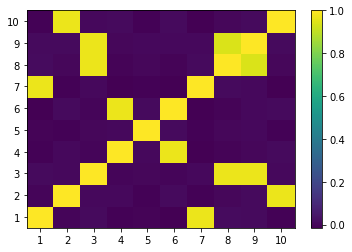

In [11]:
plotCorrMatrix(corr, labels=corr.columns)

In [14]:
# 距離行列に変換
# 1に近いと離れている
dist = correlDist(corr)

In [15]:
dist

,1,2,3,4,5,6,7,8,9,10
1,0.000000,0.708179,0.703553,0.710877,0.708879,0.711192,0.122348,0.702406,0.703058,0.710287
2,0.708179,0.000000,0.704070,0.704536,0.710430,0.703109,0.710323,0.706165,0.703662,0.119689
3,0.703553,0.704070,0.000000,0.707331,0.706478,0.707040,0.704910,0.123085,0.122392,0.704380
4,0.710877,0.704536,0.707331,0.000000,0.705085,0.120759,0.711165,0.709126,0.705544,0.703843
5,0.708879,0.710430,0.706478,0.705085,0.000000,0.703844,0.710404,0.705563,0.705371,0.709798
6,0.711192,0.703109,0.707040,0.120759,0.703844,0.000000,0.711690,0.708778,0.705361,0.702755
7,0.122348,0.710323,0.704910,0.711165,0.710404,0.711690,0.000000,0.704011,0.704545,0.712461
8,0.702406,0.706165,0.123085,0.709126,0.705563,0.708778,0.704011,0.000000,0.172087,0.706380
9,0.703058,0.703662,0.122392,0.705544,0.705371,0.705361,0.704545,0.172087,0.000000,0.703851
10,0.710287,0.119689,0.704380,0.703843,0.709798,0.702755,0.712461,0.706380,0.703851,0.000000


In [16]:
# クラスター
link=sch.linkage(dist, 'single')

C:\Users\yh_in\anaconda3\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


In [17]:
link

array([[ 1.        ,  9.        ,  0.16929634,  2.        ],
       [ 3.        ,  5.        ,  0.17079487,  2.        ],
       [ 0.        ,  6.        ,  0.17307963,  2.        ],
       [ 2.        ,  8.        ,  0.17991397,  2.        ],
       [ 7.        , 13.        ,  0.1810718 ,  3.        ],
       [ 4.        , 11.        ,  1.15427466,  3.        ],
       [12.        , 15.        ,  1.16230241,  5.        ],
       [10.        , 16.        ,  1.16473907,  7.        ],
       [14.        , 17.        ,  1.27300025, 10.        ]])

In [18]:
# クラスター順に要素を並べる
sortIx=getQuasiDiag(link)

In [19]:
sortIx

[7, 2, 8, 1, 9, 0, 6, 4, 3, 5]

In [20]:
# クラスター順に要素のインデックスを並べる
sortIx = corr.index[sortIx].tolist()

In [21]:
# 列番号
sortIx

[8, 3, 9, 2, 10, 1, 7, 5, 4, 6]

In [24]:
# 相関行列をクラスター順に並び替え
df0=corr.loc[sortIx, sortIx]

In [22]:
corr

,1,2,3,4,5,6,7,8,9,10
1,1.000000,-0.003036,0.010026,-0.010693,-0.005020,-0.011589,0.970062,0.013251,0.011418,-0.009015
2,-0.003036,1.000000,0.008572,0.007259,-0.009423,0.011275,-0.009117,0.002663,0.009720,0.971349
3,0.010026,0.008572,1.000000,-0.000634,0.001777,0.000190,0.006205,0.969700,0.970040,0.007698
4,-0.010693,0.007259,-0.000634,1.000000,0.005709,0.970834,-0.011512,-0.005719,0.004416,0.009210
5,-0.005020,-0.009423,0.001777,0.005709,1.000000,0.009208,-0.009347,0.004363,0.004903,-0.007626
6,-0.011589,0.011275,0.000190,0.970834,0.009208,1.000000,-0.013006,-0.004731,0.004932,0.012271
7,0.970062,-0.009117,0.006205,-0.011512,-0.009347,-0.013006,1.000000,0.008737,0.007234,-0.015202
8,0.013251,0.002663,0.969700,-0.005719,0.004363,-0.004731,0.008737,1.000000,0.940772,0.002055
9,0.011418,0.009720,0.970040,0.004416,0.004903,0.004932,0.007234,0.940772,1.000000,0.009188
10,-0.009015,0.971349,0.007698,0.009210,-0.007626,0.012271,-0.015202,0.002055,0.009188,1.000000


In [25]:
df0

,8,3,9,2,10,1,7,5,4,6
8,1.000000,0.969700,0.940772,0.002663,0.002055,0.013251,0.008737,0.004363,-0.005719,-0.004731
3,0.969700,1.000000,0.970040,0.008572,0.007698,0.010026,0.006205,0.001777,-0.000634,0.000190
9,0.940772,0.970040,1.000000,0.009720,0.009188,0.011418,0.007234,0.004903,0.004416,0.004932
2,0.002663,0.008572,0.009720,1.000000,0.971349,-0.003036,-0.009117,-0.009423,0.007259,0.011275
10,0.002055,0.007698,0.009188,0.971349,1.000000,-0.009015,-0.015202,-0.007626,0.009210,0.012271
1,0.013251,0.010026,0.011418,-0.003036,-0.009015,1.000000,0.970062,-0.005020,-0.010693,-0.011589
7,0.008737,0.006205,0.007234,-0.009117,-0.015202,0.970062,1.000000,-0.009347,-0.011512,-0.013006
5,0.004363,0.001777,0.004903,-0.009423,-0.007626,-0.005020,-0.009347,1.000000,0.005709,0.009208
4,-0.005719,-0.000634,0.004416,0.007259,0.009210,-0.010693,-0.011512,0.005709,1.000000,0.970834
6,-0.004731,0.000190,0.004932,0.011275,0.012271,-0.011589,-0.013006,0.009208,0.970834,1.000000


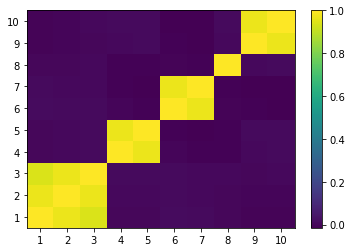

In [26]:
# 相関の高い列が隣接するようになる
plotCorrMatrix(df0, labels=corr.columns)

In [57]:
hrp=getRecBipart(cov, sortIx)

In [58]:
hrp

8     0.071408
3     0.075961
9     0.125317
2     0.067596
10    0.063236
1     0.109945
7     0.103968
5     0.193357
4     0.097549
6     0.091662
dtype: float64

# 事前準備  
時系列株価データの取得

In [3]:
from datetime import date, timedelta
from pandas_datareader import data as pdr

In [4]:
# 期間設定
today = date.today()
startday = today - timedelta(days=20)
# 銘柄設定
ticker_list = ["IBM", "AAPL", "MSFT", "C", "T"]

In [5]:
# 取得
pd_data = pdr.DataReader(ticker_list, "stooq", startday)

In [6]:
# リターン
ret = pd_data['Close'].sort_index(ascending=True)
ret=ret.pct_change().drop(ret.index[0])

In [31]:
# 共分散行列
cvm = ret.cov()

In [32]:
# 株価
prc = pd_data['Close']['IBM'].sort_index(ascending=True)

In [7]:
ret_c=ret["C"].reset_index(drop=True)

In [8]:
ret_c

0     0.007266
1    -0.005530
2     0.000242
3    -0.015470
4    -0.003437
5     0.000000
6     0.026854
7     0.016555
8     0.018173
9    -0.009968
10   -0.001639
11    0.000938
Name: C, dtype: float64

In [9]:
df1=pd.DataFrame()

In [23]:
df_=pd.DataFrame(ret_c.shift(4).copy(deep=True))

In [24]:
df_.columns = ["L4"]

In [25]:
df1=df1.join(df_, how='outer')

In [26]:
df1

,L1,L2,L3,L4
0,NaN,NaN,NaN,NaN
1,0.007266,NaN,NaN,NaN
2,-0.005530,0.007266,NaN,NaN
3,0.000242,-0.005530,0.007266,NaN
4,-0.015470,0.000242,-0.005530,0.007266
5,-0.003437,-0.015470,0.000242,-0.005530
6,0.000000,-0.003437,-0.015470,0.000242
7,0.026854,0.000000,-0.003437,-0.015470
8,0.016555,0.026854,0.000000,-0.003437
9,0.018173,0.016555,0.026854,0.000000


In [53]:
df1_bkup = x

In [45]:
x=df1.dropna()

In [47]:
x.iloc[:, 0]

4    -0.015470
5    -0.003437
6     0.000000
7     0.026854
8     0.016555
9     0.018173
10   -0.009968
11   -0.001639
Name: L1, dtype: float64

In [48]:
x

,L1,L2,L3,L4
4,-0.015470,0.000242,-0.005530,0.007266
5,-0.003437,-0.015470,0.000242,-0.005530
6,0.000000,-0.003437,-0.015470,0.000242
7,0.026854,0.000000,-0.003437,-0.015470
8,0.016555,0.026854,0.000000,-0.003437
9,0.018173,0.016555,0.026854,0.000000
10,-0.009968,0.018173,0.016555,0.026854
11,-0.001639,-0.009968,0.018173,0.016555


In [49]:
x.shape

(8, 4)

In [51]:
pd.DataFrame(ret_c).values[-9:-1,0]

array([-0.01547015, -0.00343727,  0.        ,  0.0268539 ,  0.0165547 ,
        0.01817324, -0.00996755, -0.00163896])

In [54]:
df1_bkup.iloc[:,0]=pd.DataFrame(ret_c).values[-9:-1,0]

C:\Users\yh_in\anaconda3\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [56]:
ret_c.iloc[-8:]

4    -0.003437
5     0.000000
6     0.026854
7     0.016555
8     0.018173
9    -0.009968
10   -0.001639
11    0.000938
Name: C, dtype: float64

In [57]:
ret_c

0     0.007266
1    -0.005530
2     0.000242
3    -0.015470
4    -0.003437
5     0.000000
6     0.026854
7     0.016555
8     0.018173
9    -0.009968
10   -0.001639
11    0.000938
Name: C, dtype: float64

In [33]:
pd.DataFrame(ret_c).values[-13:-1,0]

array([ 0.00726568, -0.00553018,  0.00024178, -0.01547015, -0.00343727,
        0.        ,  0.0268539 ,  0.0165547 ,  0.01817324, -0.00996755,
       -0.00163896])

In [36]:
ret_c

0     0.007266
1    -0.005530
2     0.000242
3    -0.015470
4    -0.003437
5     0.000000
6     0.026854
7     0.016555
8     0.018173
9    -0.009968
10   -0.001639
11    0.000938
Name: C, dtype: float64

In [37]:
a = list(range(0,10)) 

In [38]:
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [43]:
a[-11:-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

## コードチェック

In [2]:
pd.datetime.today()

C:\Users\yh_in\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


datetime.datetime(2023, 6, 24, 13, 15, 7, 346010)

In [3]:
pd.tseries.offsets.BDay()

<BusinessDay>

In [1]:
dict0 = {'minWLeaf':[.0], 'scoring': ['accuracy'], 'method': ['MDI', 'MDA', 'SFI'], 'max_samples': [1.]}

In [5]:
*dict0.values()

SyntaxError: can't use starred expression here (<ipython-input-5-037e8bef21e4>, line 4)

In [17]:
val = [i for i in itertools.product(*dict0.values())]

In [19]:
val

[(0.0, 'accuracy', 'MDI', 1.0),
 (0.0, 'accuracy', 'MDA', 1.0),
 (0.0, 'accuracy', 'SFI', 1.0)]

In [16]:
[dict(zip(dict0, i)) for i in itertools.product(*dict0.values())]

[{'minWLeaf': 0.0, 'scoring': 'accuracy', 'method': 'MDI', 'max_samples': 1.0},
 {'minWLeaf': 0.0, 'scoring': 'accuracy', 'method': 'MDA', 'max_samples': 1.0},
 {'minWLeaf': 0.0, 'scoring': 'accuracy', 'method': 'SFI', 'max_samples': 1.0}]

In [21]:
dict0

{'minWLeaf': [0.0],
 'scoring': ['accuracy'],
 'method': ['MDI', 'MDA', 'SFI'],
 'max_samples': [1.0]}

In [25]:
dict(zip(dict0, val[0]))

{'minWLeaf': 0.0, 'scoring': 'accuracy', 'method': 'MDI', 'max_samples': 1.0}

In [35]:
type(ret)

pandas.core.frame.DataFrame

In [36]:
ret

Symbols,IBM,AAPL,MSFT,C,T
Date,,,,,
2023-06-13,0.008650,-0.002612,0.007353,0.004954,-0.006905
2023-06-14,-0.002907,0.003491,0.009124,-0.009242,0.001264
2023-06-15,0.008746,0.011199,0.031897,0.006633,0.011995
2023-06-16,-0.006647,-0.005860,-0.016576,-0.007619,0.001871
2023-06-20,-0.011056,0.000487,-0.012503,-0.012036,-0.017435
2023-06-21,-0.016696,-0.005675,-0.013282,-0.004201,-0.010773
2023-06-22,-0.018850,0.016525,0.018437,-0.016452,-0.001922
2023-06-23,-0.013265,-0.001711,-0.013806,-0.013082,-0.008344
2023-06-26,0.014757,-0.007553,-0.019163,0.004781,0.011650


In [37]:
ret.index

DatetimeIndex(['2023-06-13', '2023-06-14', '2023-06-15', '2023-06-16',
               '2023-06-20', '2023-06-21', '2023-06-22', '2023-06-23',
               '2023-06-26', '2023-06-27', '2023-06-28', '2023-06-29'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [39]:
[i[0] for i in ret.columns]

['I', 'A', 'M', 'C', 'T']

In [8]:
for j in range(4, 4):
    print(j)

In [5]:
int(98.68239)

98

In [6]:
int(98.99)

98

## 3.1 日次ボラティリティ推定

In [8]:
close=prc

In [9]:
# 2営業日前の日付を取得
df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
df0 = df0[df0>0]
df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])

# 2営業日前からのリターン系列
df0 = close.loc[df0.index] / close.loc[df0.values].values-1

# 指数平滑加重標準偏差
df0.ewm(span=100).std()

Date
2023-04-26         NaN
2023-04-27    0.003529
2023-04-28    0.002663
2023-05-01    0.004616
2023-05-02    0.007250
2023-05-03    0.011076
2023-05-04    0.012151
2023-05-05    0.011511
2023-05-08    0.010755
2023-05-09    0.011319
2023-05-10    0.010800
2023-05-11    0.010332
2023-05-12    0.010547
Name: IBM, dtype: float64

In [10]:
df0

Date
2023-04-26    0.003589
2023-04-27    0.008579
2023-04-28    0.004450
2023-05-01   -0.002531
2023-05-02   -0.009888
2023-05-03   -0.020937
2023-05-04   -0.020694
2023-05-05    0.001620
2023-05-08   -0.002022
2023-05-09   -0.020057
2023-05-10   -0.011183
2023-05-11   -0.002228
2023-05-12    0.006720
Name: IBM, dtype: float64

## 2.1 リスク分布RのPCAウェイト  
各主成分のリスク寄与が指定した配分となるような資産ウェイトを算出

In [36]:
# パラメータ設定（共分散行列、リスク水準）
cov = cvm
riskTarget = 1

In [22]:
# 固有値、固有ベクトル（入力はエルミート行列である必要がある⇒下三角行列で固有値を算出するため）
eVal, eVec = np.linalg.eigh(cov)

In [23]:
# 降順ソートのインデックス順列
indices = eVal.argsort()[::-1]

In [24]:
# 固有値降順で並び替え
eVal, eVec = eVal[indices], eVec[:, indices]

In [29]:
# デフォルトのリスク分布を設定（固有値最低の主成分に全て配分）
riskDist = np.zeros(cov.shape[0])
riskDist[-1] = 1

In [37]:
# 設定したリスク分布となる資産ウェイトの算出
loads = riskTarget*riskDist/eVal**.5
wghts = np.dot(eVec, np.reshape(loads, (-1, 1)))

In [9]:
prc = pd_data["Close"]["IBM"].sort_index(ascending=True)

In [12]:
diff = prc.diff()

In [2]:
4**-0.5

0.5